In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
print(os.listdir("../input"))

from glob import glob 
from skimage.io import imread
import gc

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input,ZeroPadding2D,Conv2D, Cropping3D, MaxPooling2D, BatchNormalization, Activation, Dense, Flatten, Dropout,SpatialDropout2D, Cropping2D
from keras.models import Model
from glob import glob 
import tensorflow as tf

os.listdir()

['train.csv', 'test.csv']


['train_ims',
 'Hist_model1_fullim.h5',
 'Hist_model1_fullim_9epochs.h5',
 '.train_ims',
 'Hist_model1_ROI.h5',
 'Histo_model.ipynb',
 'submission.csv',
 '.ipynb_checkpoints',
 'MNIST_data',
 'sample_submission.csv',
 'test_ims',
 'Hist_model1_simple.h5',
 'Histo_triplet_model.ipynb',
 'Untitled1.ipynb',
 'Histo-EDA.ipynb',
 'Untitled.ipynb',
 'train_labels.csv']

In [2]:
train_labels = pd.read_csv('./train_labels.csv') ## read in file
train_labels['filepath'] = [''+x+'.tif' for x in train_labels['id']] ## add filepath column
train_labels['label_str'] = [str(x) for x in train_labels['label']] ## add filepath column
train_labels.set_index('id', inplace = True) ## set index to 'id' value
train_labels = train_labels.reindex(columns=['filepath','label','label_str']) ## switch column order
train_labels = train_labels.reset_index()

test_df = pd.read_csv('./sample_submission.csv') ## read in file
test_df['filepath'] = [''+x+'.tif' for x in test_df['id']] ## add filepath column
test_df.set_index('id', inplace = True) ## set index to 'id' value
test_df = test_df.reindex(columns=['filepath','label']) ## switch column order
test_df = test_df.reset_index()


def read_image_file(filepath):
    ## takes in filename of image - given in the labels file
    ## example: call read_image_file(train_labels['filepath'].sample(1).values[0])
    return plt.imread('./train_ims/'+filepath)

In [3]:
train_labels.head(3)

,id,filepath,label,label_str
0,f38a6374c348f90b587e046aac6079959adf3835,f38a6374c348f90b587e046aac6079959adf3835.tif,0,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1,1
2,755db6279dae599ebb4d39a9123cce439965282d,755db6279dae599ebb4d39a9123cce439965282d.tif,0,0


In [4]:
## Split into train and validation sets
train_df, cv_df = train_test_split(train_labels, test_size = 0.1)

In [5]:
## Unique values of the labels
print(set(train_df['label'].values))
print(set(cv_df['label'].values))

{0, 1}
{0, 1}


Define center coordinates and display example images

As stated in the data description this is the center 32x32 pixels. The image is symmetrical

The surround may or may not contain cancerous tissue

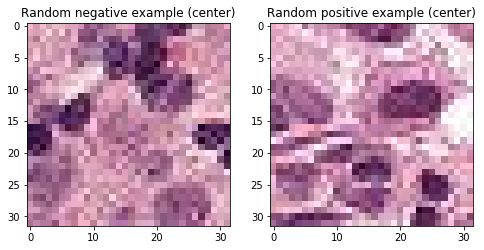

In [6]:
A = read_image_file(train_df[train_df.label == 0]['filepath'].sample(1).values[0])
B = read_image_file(train_df[train_df.label == 1]['filepath'].sample(1).values[0])

c_min = int(A.shape[0]/2-16)
c_max = int(A.shape[0]/2+16)
#print('Center coords %d x %d' %(c_min,c_max))

plt.figure(figsize = (8,5))
plt.subplot(121)
plt.imshow(A[c_min:c_max,c_min:c_max])
plt.title('Random negative example (center)')
plt.subplot(122)
plt.title('Random positive example (center)')
plt.imshow(B[c_min:c_max,c_min:c_max])

In [7]:
## Other kernels have removed this image, but I didn't find an error with it.
#err_im  = train_df[train_df['id'] == '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

# removing this image because it's black
#df_data = df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

In [8]:
N_train = len(train_df)
pos = sum(train_df['label'])
N_cv = len(cv_df)
pos_cv = sum(cv_df['label'])
A = read_image_file(train_df[train_df.label == 0]['filepath'].sample(1).values[0])
print('image dimensions %d x %d'%(A.shape[0],A.shape[1]))
print('N training examples: %d '%N_train)
print('Pct positive training examples: %.3f'%(pos/N_train))
print('N validation examples %d'%N_cv)
print('Pct positive validation examples: %.3f'%(pos_cv/N_cv))

image dimensions 96 x 96
N training examples: 198022 
Pct positive training examples: 0.405
N validation examples 22003
Pct positive validation examples: 0.407


In [9]:
## Data augmentation for the train input
train_datagen = ImageDataGenerator(rescale=1./255)#,
                #horizontal_flip=True)

## Create the flow_from_dataframe generator, to avoid loading in all images,
## and to avoid copying files into a new directory
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory= './train_ims/', ## Not already includded in filename
    x_col='filepath',
    y_col='label_str',
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    shuffle=True)
#    seed=42)

## Data augmentation for the validation input
valid_datagen = ImageDataGenerator(rescale=1./255)#,

validation_generator = valid_datagen.flow_from_dataframe(
    dataframe = cv_df,
    directory= './train_ims/', ## Not already included in filename
    x_col='filepath',
    y_col='label_str', ## for some reason this needs to be a string for this generator to work
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary")

Found 198022 validated image filenames belonging to 2 classes.
Found 22003 validated image filenames belonging to 2 classes.


## First build a simple baseline model with the 96x96 inputs

In [10]:
'''
tdx = tf.placeholder(tf.float32,[96,96,3])
X_input = Input(tf.image.crop_to_bounding_box(tdx, 32,32,32,32))
X = Conv2D(3, (3, 3), name = 'conv0_1')(X_input)
X = Flatten()(X)
X = Dense(1, activation = "sigmoid", name='fc')(X)
model = Model(inputs = X_input, outputs = X)

model.add(Cropping2D(cropping=((2, 2), (4, 4)),
                         input_shape=(28, 28, 3)))
\
;'''

'\ntdx = tf.placeholder(tf.float32,[96,96,3])\nX_input = Input(tf.image.crop_to_bounding_box(tdx, 32,32,32,32))\nX = Conv2D(3, (3, 3), name = \'conv0_1\')(X_input)\nX = Flatten()(X)\nX = Dense(1, activation = "sigmoid", name=\'fc\')(X)\nmodel = Model(inputs = X_input, outputs = X)\n\nmodel.add(Cropping2D(cropping=((2, 2), (4, 4)),\n                         input_shape=(28, 28, 3)))\n;'

For a positive image, want 
distance_to_match + alpha - distance_to_non_match < 0

For a negative image, want 
distance_to_non_match + alpha - distance_to_match < 0

In [54]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """    
    Arguments:
    y_true -- true labels (unused, requered for a Keras loss)
    y_pred -- anchor -- the encodings for an anchor image, of shape (None, Ndense)
              positive -- the encodings for a positive images, of shape (None, Ndense)
              negative -- the encodings for a negative images, of shape (None, Ndense)
    Returns:
    loss -- real number, value of the loss
    """
    center, side, corner = y_pred[0], y_pred[1], y_pred[2]
    
    ## perhaps normalize first
    #center = BatchNormalization(axis = -1)(center)
    #side = BatchNormalization(axis = -1)(side)
    #corner = BatchNormalization(axis = -1)(corner)


    if y_true == 1: ## for a positive example - assume the center is the only positive part
                
        noncenter_dist = tf.reduce_sum(tf.square(side-corner),axis = -1) ## distance to minimize
        to_center_dist = tf.reduce_sum(tf.square(center-side),axis = -1) ## distance to maximize
    
        basic_loss = noncenter_dist-to_center_dist+alpha
    
    if y_true == 0: ## for a positive example - assume the center is the only positive part
        noncenter_dist = tf.reduce_sum(tf.square(side-corner),axis = -1)
        to_center_dist = tf.reduce_sum(tf.square(center-side),axis = -1)

        basic_loss = to_center_dist - noncenter_dist+alpha
    
    loss = tf.reduce_sum(tf.maximum(basic_loss,tf.constant([0.0])),axis = 0)
    
    return loss

In [62]:
def model_main_block(X):
    
    X = Conv2D(32, (3, 3), strides = (1,1), name = 'conv0_1')(X)
    X = Conv2D(32, (3, 3), name = 'conv0_2', use_bias=False)(X)
    X = BatchNormalization(axis = -1, name = 'bn0')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool0')(X)
    X = SpatialDropout2D(0.3)(X)
        
    '''
    X = Conv2D(64, (3, 3), name = 'conv1_1', use_bias=False)(X)
    X = BatchNormalization(axis = -1, name = 'bn1_1')(X)
    X = Activation('relu')(X)
    X = Conv2D(64, (3, 3), name = 'conv1_2', use_bias=False)(X)
    X = BatchNormalization(axis = -1, name = 'bn1_2')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool1')(X)
    X = SpatialDropout2D(0.3)(X)


    X = Conv2D(128, (3, 3), name = 'conv2_1', use_bias=False)(X)
    X = BatchNormalization(axis = -1, name = 'bn2_1')(X)
    X = Activation('relu')(X)
    X = Conv2D(128, (3, 3), name = 'conv2_2', use_bias=False)(X)
    X = BatchNormalization(axis = -1, name = 'bn2_2')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool2')(X)
    X = SpatialDropout2D(0.3)(X)
    '''
    
    X = Flatten()(X)
    
    # NOTE: Option to ass a FC layer here but
    X = Dense(128, name='d128')(X)
    X = BatchNormalization(axis = -1, name = 'bn_dense')(X)
    X = Activation('relu')(X)
    X = Dropout(0.5)(X)

    return X


In [63]:
def triplet_model(input_shape):

    X_input = Input(input_shape)
    
    X_center = tf.image.crop_to_bounding_box(X_input, 32,32,32,32)
   # X_side = tf.image.crop_to_bounding_box(X_input, 0,32,32,32)
   # X_corner = tf.image.crop_to_bounding_box(X_input, 0,32,32,32)
    
    X = model_main_block(X_center)
    
#    X_anc = Cropping2D(cropping= ((c_min, c_min), (c_max, c_max),(0, 3)), input_shape=(None, 96, 96, 3))(X_input)
 #   X = tf.image.crop_to_bounding_box(X_input, 32,32,32,32)

    ## option to clip the input to just the ROI
    # CONV -> BN -> RELU Block applied to X

    ## Output layer
    #X = Dense(1, activation = "sigmoid", name='fc')(X)

    
    model = Model(inputs = X_input, outputs = X, name='triplet_mod')
    #model = Model(inputs = X_input, outputs = [X_center,X_side,X_corner], name='triplet_mod')
    
    return model



In [64]:
HistoModel_triplet = triplet_model([96,96,3])
#HistoModel_triplet.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
HistoModel_triplet.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

AttributeError: 'NoneType' object has no attribute '_inbound_nodes'

In [53]:
history = HistoModel.fit_generator(train_generator,
        steps_per_epoch= 10,#len(train_df)/32,
        epochs=1,
        validation_data=validation_generator,
        validation_steps=50)#len(cv_df)/32)

Epoch 1/1
10/10 [==============================] - 55s 5s/step - loss: 0.9484 - acc: 0.6000 - val_loss: 2.9119 - val_acc: 0.6106


In [23]:
HistoModel.save_weights('Hist_model1_fullim_9epochs.h5')

In [34]:
HistoModel.get_config()

{'name': '2BlockModel',
 'layers': [{'name': 'input_3',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 96, 96, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_3'},
   'inbound_nodes': []},
  {'name': 'conv0_1',
   'class_name': 'Conv2D',
   'config': {'name': 'conv0_1',
    'trainable': True,
    'filters': 32,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'inbound_nodes': [[['input_3', 0, 0, {}]]]},
  {'name': 'co

In [ ]:
'''
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
'''

In [26]:
# make a prediction
y_pred_val = HistoModel.predict_generator(validation_generator, steps=len(cv_df)/32, verbose=1)

688/687 [==============================] - 404s 588ms/step


In [27]:
print(len(y_pred_val))

print(len(cv_df))
cv_pred = np.asarray([x[0] for x in y_pred_val])
cv_pred[0:10]

22003
22003


array([0.0376787 , 0.01347985, 0.23905309, 0.33027792, 0.96332026,
       0.33686602, 0.01013121, 0.5602759 , 0.00258632, 0.00795443],
      dtype=float32)

0.5079535884907596
0.5325182929600509


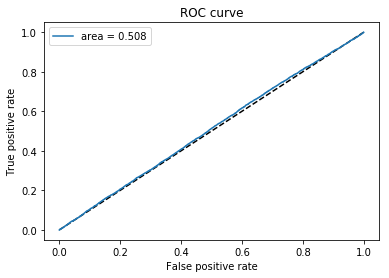

In [35]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

fpr_keras, tpr_keras, thresholds_keras = roc_curve(validation_generator.classes, cv_pred)
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)
cv_pred_bin = cv_pred>0.6
print(sum(validation_generator.classes == cv_pred_bin)/len(cv_pred_bin))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)#,
test_generator = test_datagen.flow_from_dataframe(
        dataframe = test_df,
        directory= './test_ims/', ## Not already included in filename
        x_col='filepath',
        y_col= None, ##
        target_size=(96,96),
        class_mode=None,
        color_mode="rgb",
        batch_size=32,
        shuffle=False)

In [ ]:
# make sure we are using the best epoch
#model.load_weights('Hist_model1_ROI.h5')
test_generator.reset()
test_predictions = HistoModel.predict_generator(test_generator, steps = len(test_df)/32, verbose=1)
test_pred = [x[0] for x in test_predictions]

In [ ]:
#test_df['label'] = test_pred
submission = test_df[['id','label']]

In [ ]:
submission.to_csv("submission.csv", index = False, header = True)